## Import Libraries

In [1]:
import torch
import os
import glob
import cv2
import numpy as np
import pandas as pd
from unet_model import UNet
import random
import torch.utils.data as data
import albumentations as A
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
# !cat unet_model.py
def set_seed(seed = 0):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed()

In [4]:
model = UNet(n_channels=3, n_classes=1)

In [5]:
# print(model)

In [6]:
model.load_state_dict(torch.load('data/brain-mri-unet.pth'))

<All keys matched successfully>

In [7]:
def image_channels(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is not None:
        num_channels = image.shape[2] if len(image.shape) == 3 else 1
    else:
        num_channels = 0  # Handle cases where the image couldn't be loaded
    return num_channels

def mask_channels(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if mask is not None:
        num_channels = mask.shape[2] if len(mask.shape) == 3 else 1
    else:
        num_channels = 0  # Handle cases where the mask couldn't be loaded
    return num_channels
ROOT_PATH2 = 'test_TCGA'

# Find image and mask files using glob
image_files2 = glob.glob(os.path.join(ROOT_PATH2, '*_image*'))
mask_files2 = glob.glob(os.path.join(ROOT_PATH2, '*_mask*'))

ind_test_df = pd.DataFrame({
    "image_path": image_files2,
    "mask_path": [file.replace('_image', '_mask') for file in image_files2],
    "image_channels": [image_channels(file) for file in image_files2],
    "mask_channels": [mask_channels(file.replace('_image', '_mask')) for file in image_files2]
})
print(ind_test_df)


                                           image_path  \
0   test_TCGA/dir1_image_TCGA_HT_A61A_20000127_TCG...   
1   test_TCGA/dir1_image_TCGA_HT_A61A_20000127_TCG...   
2   test_TCGA/dir1_image_TCGA_HT_A61A_20000127_TCG...   
3   test_TCGA/dir1_image_TCGA_HT_A61A_20000127_TCG...   
4   test_TCGA/dir1_image_TCGA_HT_A61A_20000127_TCG...   
..                                                ...   
78  test_TCGA/dir1_image_TCGA_HT_A61A_20000127_TCG...   
79  test_TCGA/dir1_image_TCGA_HT_A61A_20000127_TCG...   
80  test_TCGA/dir1_image_TCGA_HT_A61A_20000127_TCG...   
81  test_TCGA/dir1_image_TCGA_HT_A61A_20000127_TCG...   
82  test_TCGA/dir1_image_TCGA_HT_A61A_20000127_TCG...   

                                            mask_path  image_channels  \
0   test_TCGA/dir1_mask_TCGA_HT_A61A_20000127_TCGA...               3   
1   test_TCGA/dir1_mask_TCGA_HT_A61A_20000127_TCGA...               3   
2   test_TCGA/dir1_mask_TCGA_HT_A61A_20000127_TCGA...               3   
3   test_TCGA/dir1_mask

## Converting to PyTorch dataset format

In [8]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        
        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask

In [9]:
no_augmentation_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
])

In [10]:
batch_size = 64

test_combined = BrainDataset(ind_test_df, no_augmentation_transform)
ind_test_dl = DataLoader(test_combined, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)

In [11]:
print(test_combined)

## Calculating Dice 

In [12]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

In [13]:
def calculate_test_dice(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_dice_scores = []
    
    for image, mask in test_loader:
        image = image.to(device)
        mask = mask.to(device)
        
        with torch.no_grad():
            outputs = model(image)
        
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            
        
        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        test_dice_scores.append(dice)
    
    # Calculate the mean Dice score for the entire test dataset
    mean_dice = np.mean(test_dice_scores)
    
    return mean_dice

In [14]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

## Saving the Model

In [15]:
def calculate_test_dice(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_dice_scores = []
    
    for image, mask in test_loader:
        image = image.to(device)
        mask = mask.to(device)
        
        with torch.no_grad():
            outputs = model(image)
        
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            
        
        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        test_dice_scores.append(dice)
    
    # Calculate the mean Dice score for the entire test dataset
    mean_dice = np.mean(test_dice_scores)
    
    return mean_dice


In [16]:
test_dice = calculate_test_dice(model, ind_test_dl)
print(f"Mean Dice Score for Test Dataset: {test_dice:.4f}")

Mean Dice Score for Test Dataset: 0.8835


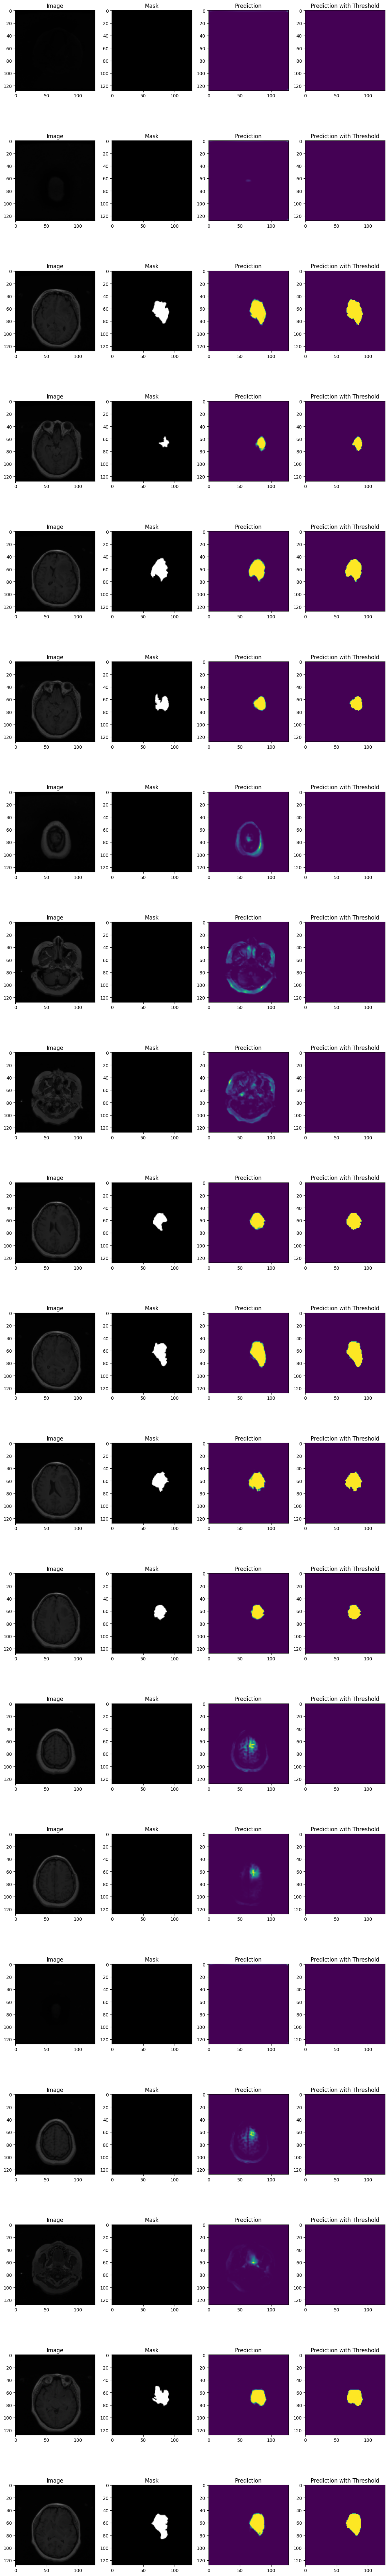

In [17]:
def visualize_test_samples(num_samples=20, threshold=0.3):
    test_samples = ind_test_df.sample(num_samples).values

    fig, axes = plt.subplots(num_samples, 4, figsize=(12, num_samples * 4))

    for i, test_sample in enumerate(test_samples):
        image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
        mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

        # Prepare the image for prediction
        pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
        pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
        pred = model(pred.to(device))
        pred = pred.detach().cpu().numpy()[0, 0, :, :]

        # Apply a threshold to the prediction
        pred_thresholded = np.copy(pred)
        pred_thresholded[np.nonzero(pred_thresholded < threshold)] = 0.0
        pred_thresholded[np.nonzero(pred_thresholded >= threshold)] = 255.
        pred_thresholded = pred_thresholded.astype("uint8")

        # Plot images, masks, predictions, and thresholded predictions
        axes[i, 0].imshow(image)
        axes[i, 0].set_title("Image")

        axes[i, 1].imshow(mask)
        axes[i, 1].set_title("Mask")

        axes[i, 2].imshow(pred, cmap='viridis')
        axes[i, 2].set_title("Prediction")

        axes[i, 3].imshow(pred_thresholded, cmap='viridis')
        axes[i, 3].set_title("Prediction with Threshold")

    plt.tight_layout()
    plt.show()

visualize_test_samples(num_samples=20, threshold=0.3)
